In [1]:
library(scran)
library(scds)
library(scDblFinder)
library(Seurat)
library(Matrix)
library(cowplot) 
library(gridExtra)
library(dplyr)
library(clustree)
library(DT)
library(pheatmap)
library(RColorBrewer)
library(gplots)
library(pracma)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
   

<h3>CL1-0-P</h3>

In [2]:
PATH <- "CL1-0-P-4"
data_dir <- paste0("/mnt/isilonX200/scRNA/Project_1/GRCh38_20200320/", PATH, "/outs/filtered_feature_bc_matrix/")
LABEL <- "CL1-0-P-4"

In [3]:
data <- Read10X(data.dir = data_dir)
colnames(data) <- paste(colnames(data), LABEL, sep = "-")
sc.data <- CreateSeuratObject(counts = data, project = "Project_1", min.cells = 0)

<h4><u>Doublelet annotation</u></h4>

In [4]:
# Using scran - doubletCells
mat <- sc.data@assays$RNA
mat <- as.matrix(mat[1:nrow(mat),1:ncol(mat)])
dbl.dens <- doubletCells(mat)

In [5]:
# cxds
sce <- as.SingleCellExperiment(sc.data)
sce = cxds(sce,retRes = TRUE)
sce = bcds(sce,retRes = TRUE,verb=TRUE)
sce = cxds_bcds_hybrid(sce)

-> selecting genes


-> simulating doublets


-> training classifier


-> done.





Clustering cells...

Identifying top genes per cluster...

Creating ~10000 artifical doublets...

Finding KNN...

Evaluating cell neighborhoods...

Finding threshold...

Threshold found:0.957



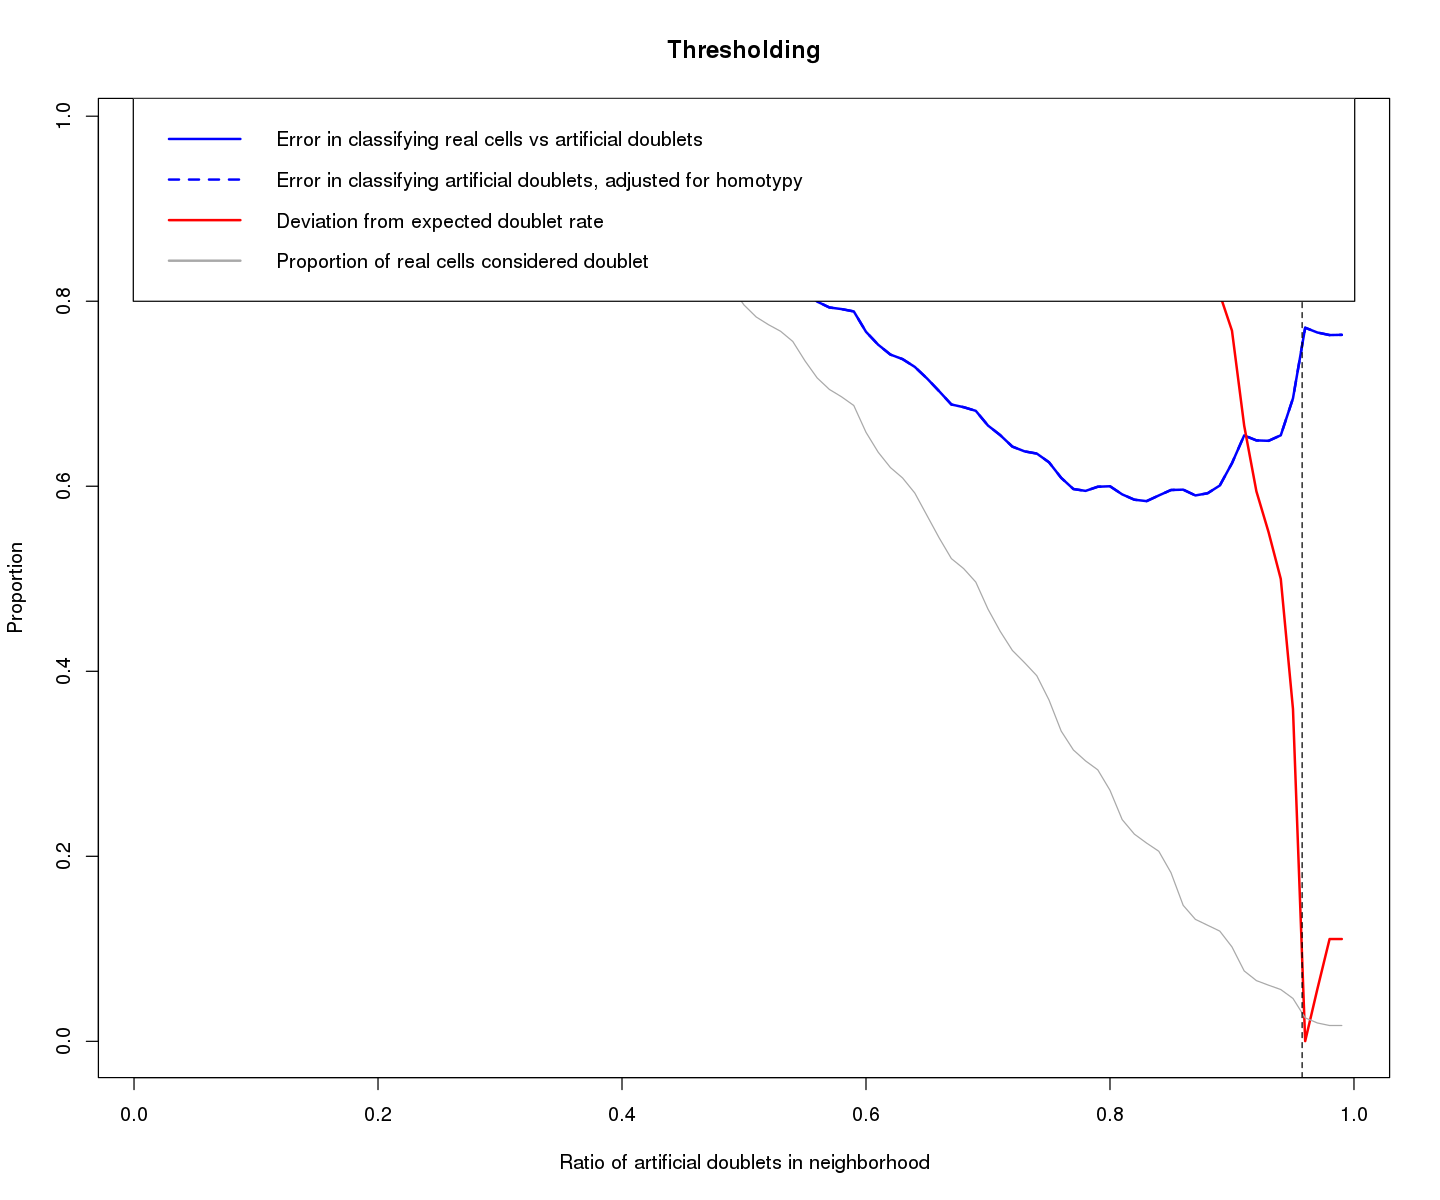

In [6]:
# scDblFinder (mimicing doubletFinder)
options(repr.plot.width=12, repr.plot.height=10)
sce <- scDblFinder(sce, dbr = 0.03, artificialDoublets = 10000) #製作10000 Fake doublelet cell，再用KNN找出靠近的cell，再去標記

In [7]:
str(sce)

Formal class 'SingleCellExperiment' [package "SingleCellExperiment"] with 9 slots
  ..@ int_elementMetadata:Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. ..@ rownames       : NULL
  .. .. ..@ nrows          : int 33538
  .. .. ..@ listData       : Named list()
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ int_colData        :Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. ..@ rownames       : NULL
  .. .. ..@ nrows          : int 3626
  .. .. ..@ listData       :List of 2
  .. .. .. ..$ reducedDims:Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. .. .. .. ..@ rownames       : NULL
  .. .. .. .. .. ..@ nrows          : int 3626
  .. .. .. .. .. ..@ listData       : Named list()
  .. .. .. .. .. ..@ elementType    : chr "ANY"
  .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. ..@ metadata       : list()
  .. .. .. ..$ altExps    :Formal class 'DFrame' [package

In [8]:
sc.data[["doubletCells"]] <- dbl.dens
sc.data[["cxds"]] <- sce$cxds_score
sc.data[["bcds"]] <- sce$bcds_score
sc.data[["hybrid"]] <- sce$hybrid_score
sc.data[["scDblFinder"]] <- sce$scDblFinder.score
sc.data[["doublets"]] <- sce$scDblFinder.class

In [9]:
head(sc.data[[]])

,orig.ident,nCount_RNA,nFeature_RNA,doubletCells,cxds,bcds,hybrid,scDblFinder,doublets
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AAACCTGAGGATATAC-CL1-0-P-4,Project_1,34903,5160,121.01040,13.012370,0.46978697,0.58530767,0.6028152,singlet
AAACCTGAGGGTCTCC-CL1-0-P-4,Project_1,57950,6302,49.39488,44.201066,0.46641085,0.85135646,0.7426604,singlet
AAACCTGCAAGCCTAT-CL1-0-P-4,Project_1,28026,4589,64.92778,5.014425,0.16951385,0.21000584,1.0000000,doublet
AAACCTGCACAGTCGC-CL1-0-P-4,Project_1,44235,5270,15.81673,6.841152,0.06629390,0.12053466,1.0000000,doublet
AAACCTGCACATTTCT-CL1-0-P-4,Project_1,50947,5666,59.15941,4.428917,0.05308029,0.08621715,0.4105997,singlet
AAACCTGGTGACTACT-CL1-0-P-4,Project_1,4449,1711,0.00000,1.101547,0.07984138,0.08475520,0.3929942,singlet


In [10]:
doublets_count <- nrow(subset(sc.data[[]], doublets=="doublet"))
singlets_count <- nrow(subset(sc.data[[]], doublets=="singlet"))
print(paste0("Doublets: ", doublets_count/(doublets_count+singlets_count)*100, "%"))
print(paste0("singlets: ", singlets_count/(doublets_count+singlets_count)*100, "%"))

[1] "Doublets: 2.59238830667402%"
[1] "singlets: 97.407611693326%"


In [11]:
# Save Rds
#CL10P.doublet <- sc.data@meta.data
#save(CL10P.doublet, file = '/mnt/isilonX200/scRNA/Project_1/Result/CL10P.doublet.Rdata')

<h3>Quality Control</h3>

In [12]:
sc.data@meta.data$condition <- LABEL
sc.data[["percent.MT"]] <- PercentageFeatureSet(sc.data, pattern = "^MT-",assay = "RNA")

Warning message:
"Using shapes for an ordinal variable is not advised"
Warning message:
"Removed 13 rows containing missing values (geom_point)."


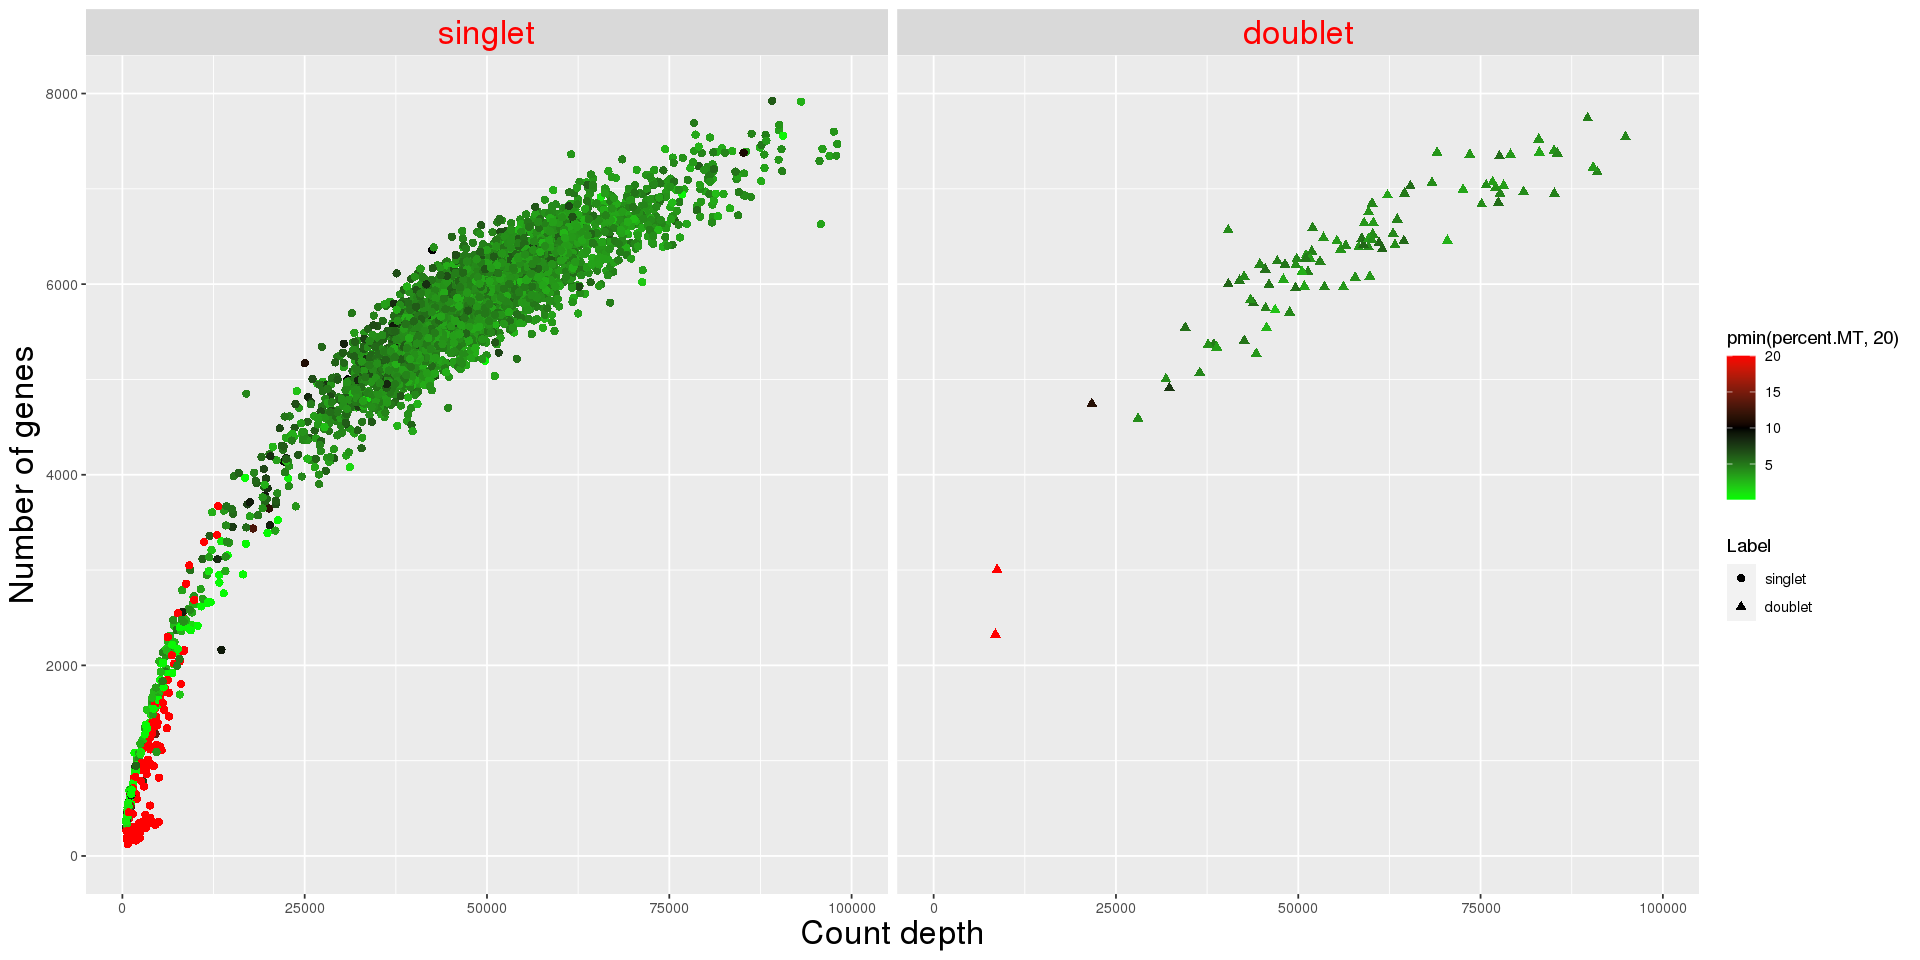

In [13]:
options(repr.plot.width=16, repr.plot.height=8)
Label <- factor(sc.data@meta.data$doublets, ordered = TRUE, levels = c('singlet', 'doublet'))
ggplot(data.frame(sc.data@meta.data, Label = Label), aes(x = nCount_RNA, y = nFeature_RNA, color = pmin(percent.MT, 20), shape = Label)) +
       theme(axis.title = element_text(size = 20), strip.text.x = element_text(size = 20, color = "red")) +
       xlim(0, 100000) + 
       ylim(0, 8000) +
       scale_color_gradient2(low="green", mid = 'black', high="red", midpoint = 10)+ 
       geom_point(size = 2) + 
       labs(x = "Count depth", y = "Number of genes", size = 6) + 
       facet_grid(. ~ Label)

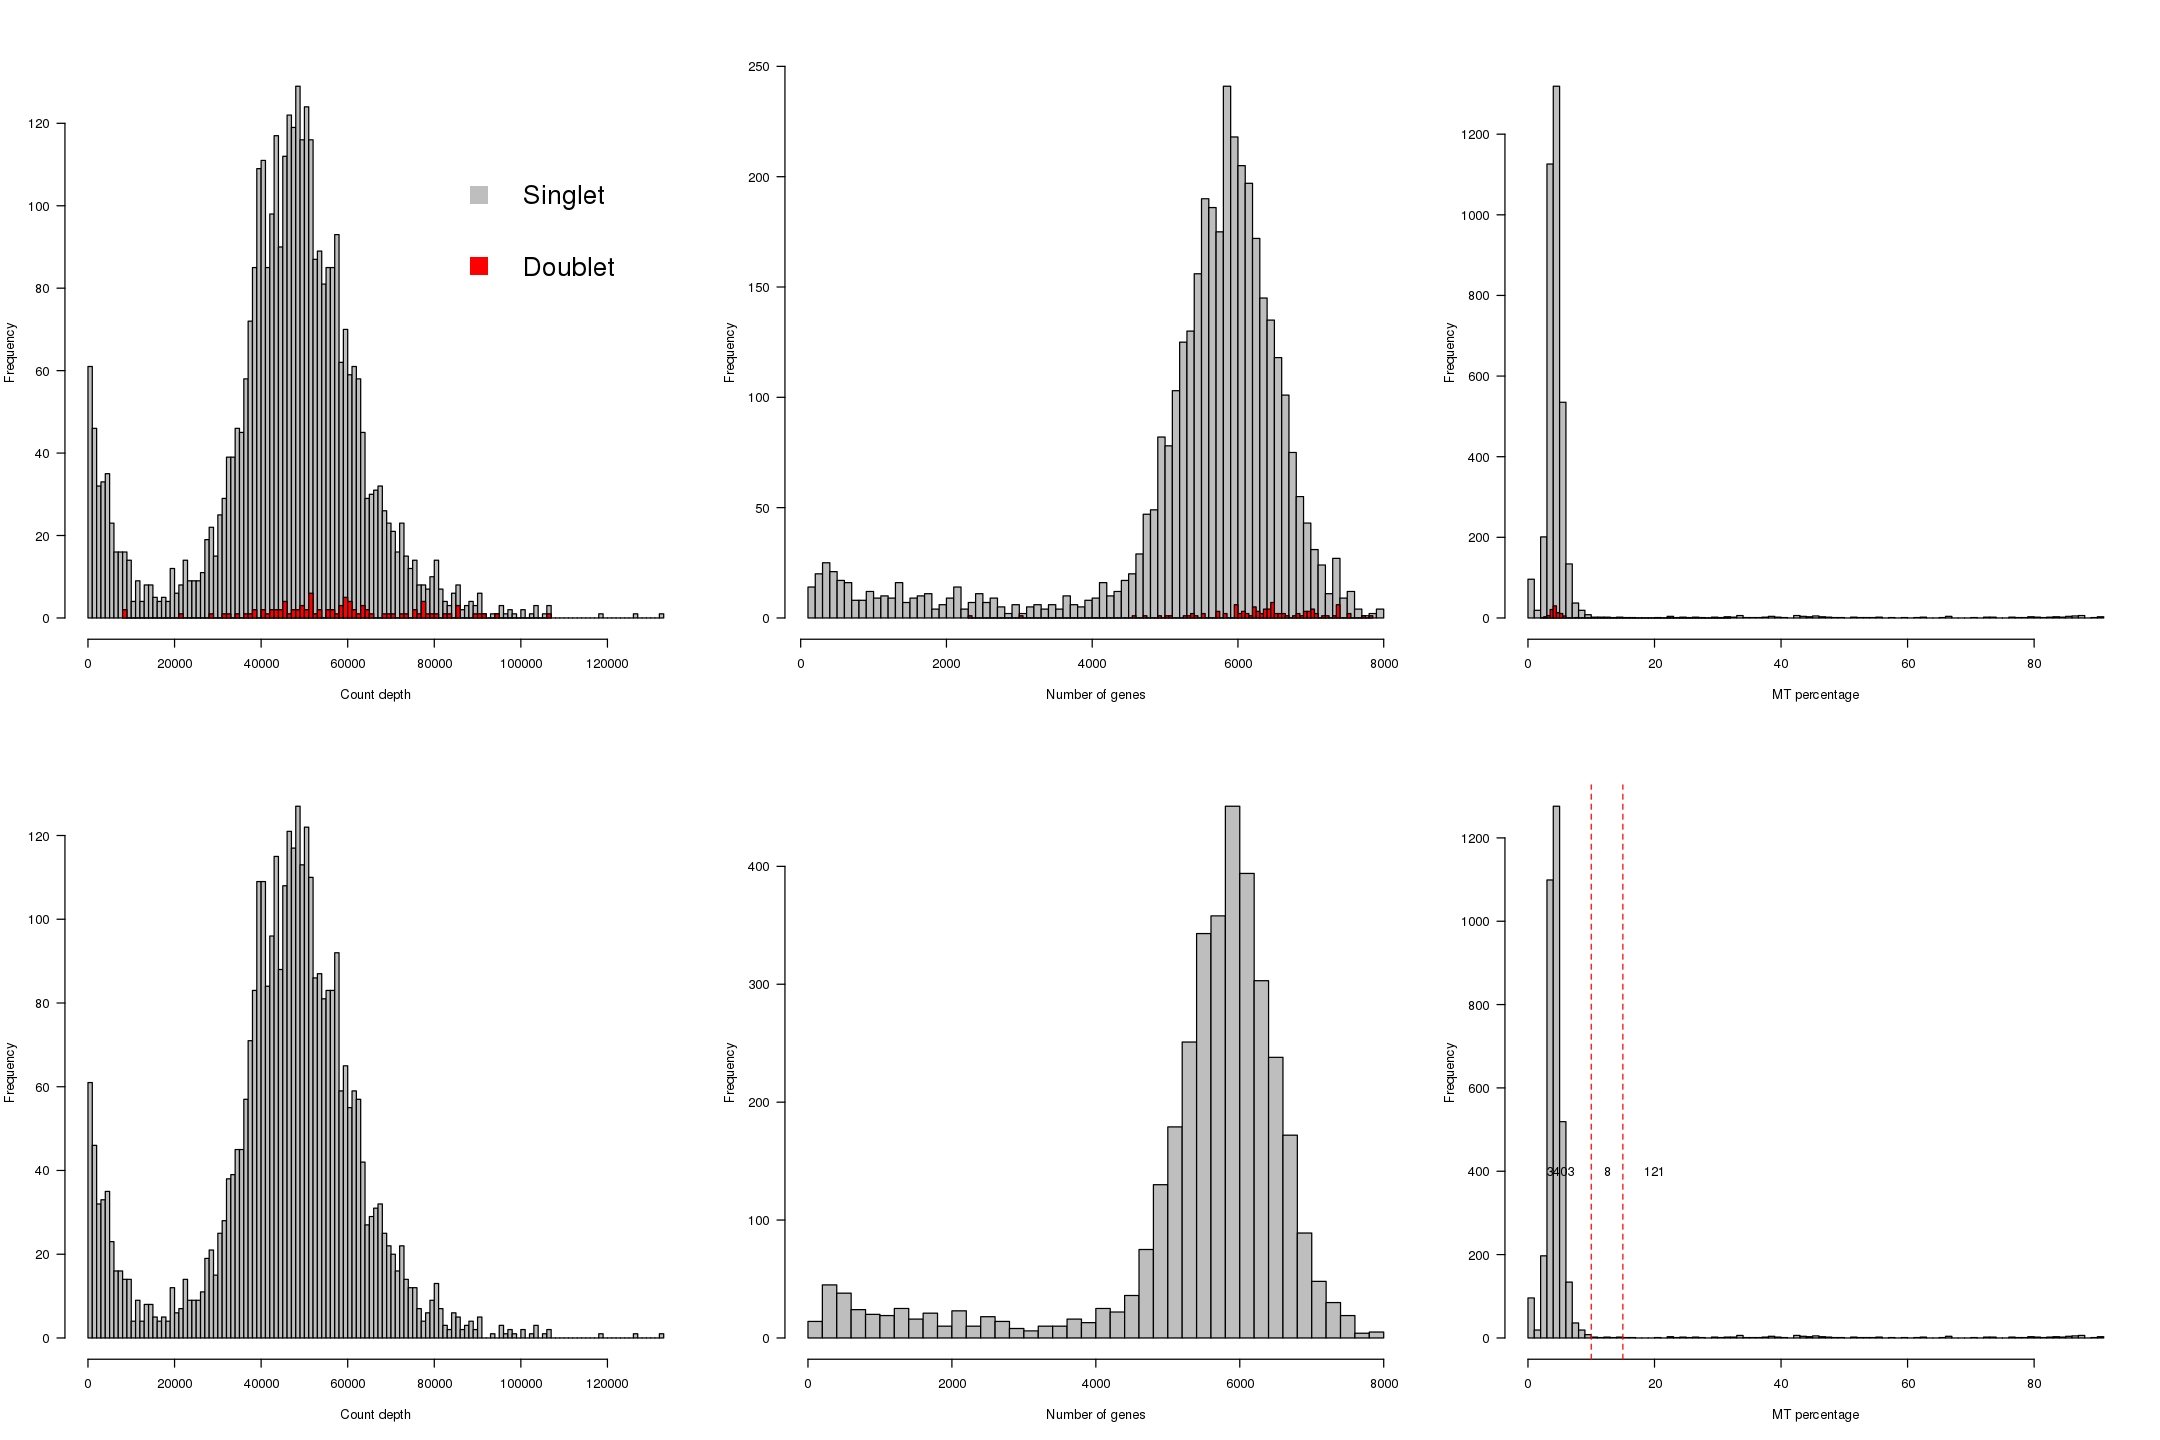

In [14]:
options(repr.plot.width=18, repr.plot.height=12)
par(mfrow = c(2, 3), las=1)
hist(sc.data$nCount_RNA, 100, main = '', xlab = 'Count depth', col = 'gray')
hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'doublet')), 'nCount_RNA'], 100, col = 'red', add = TRUE)
legend(70000, 120, pch = 15, col = c('gray', 'red'), c('Singlet', 'Doublet'), cex = 2, pt.cex = 3, bty = "n" , x.intersp=0.5)
hist(sc.data$nFeature_RNA, 100, main = '', xlab = 'Number of genes', col = 'gray')
hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'doublet')), 'nFeature_RNA'], 100, col = 'red', add = TRUE)
hist(sc.data$percent.MT, 100, main = '', xlab = 'MT percentage', col = 'gray')
hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'doublet')), 'percent.MT'], 50, col = 'red', add = TRUE)

hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'singlet')), 'nCount_RNA'], 100, main = '', xlab = 'Count depth', col = 'gray')
hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'singlet')), 'nFeature_RNA'], 50, main = '', xlab = 'Number of genes', col = 'gray')
hist(sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'singlet')), 'percent.MT'], 100, main = '', xlab = 'MT percentage', col = 'gray')
abline(v = c(10, 15), col = 'red', lty = 2)
text(c(5, 12.5, 20), 400,
     table((sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'singlet')), 'percent.MT'] >= 10) + 
          (sc.data@meta.data[rownames(subset(sc.data@meta.data, doublets == 'singlet')), 'percent.MT'] >= 15)))

In [15]:
output <- subset(sc.data, subset = doublets == 'singlet')
output <- subset(output, subset = percent.MT <= 10)

In [16]:
str(output)

Formal class 'Seurat' [package "Seurat"] with 12 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "Seurat"] with 8 slots
  .. .. .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:19018835] 14 21 22 26 27 39 41 43 45 47 ...
  .. .. .. .. .. ..@ p       : int [1:3404] 0 5160 11462 17128 23540 29982 36331 42392 47437 53533 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 33538 3403
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:33538] "MIR1302-2HG" "FAM138A" "OR4F5" "AL627309.1" ...
  .. .. .. .. .. .. ..$ : chr [1:3403] "AAACCTGAGGATATAC-CL1-0-P-4" "AAACCTGAGGGTCTCC-CL1-0-P-4" "AAACCTGCACATTTCT-CL1-0-P-4" "AAACGGGGTCCCTACT-CL1-0-P-4" ...
  .. .. .. .. .. ..@ x       : num [1:19018835] 1 2 1 43 13 8 1 5 2 1 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ data         :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:190

In [17]:
output@assays$logCPM <- (NormalizeData(object = output, verbose = FALSE)@assays$RNA)

In [18]:
output@meta.data <- output@meta.data[, c('orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'percent.MT')]
CL10P <- output
saveRDS(object = CL10P, file = '/mnt/isilonX200/scRNA/Project_1/Result/CL10P.qc.Rds')

In [19]:
output@assays$logCPM@data

   [[ suppressing 32 column names 'AAACCTGAGGATATAC-CL1-0-P-4', 'AAACCTGAGGGTCTCC-CL1-0-P-4', 'AAACCTGCACATTTCT-CL1-0-P-4' ... ]]

   [[ suppressing 32 column names 'AAACCTGAGGATATAC-CL1-0-P-4', 'AAACCTGAGGGTCTCC-CL1-0-P-4', 'AAACCTGCACATTTCT-CL1-0-P-4' ... ]]

   [[ suppressing 32 column names 'AAACCTGAGGATATAC-CL1-0-P-4', 'AAACCTGAGGGTCTCC-CL1-0-P-4', 'AAACCTGCACATTTCT-CL1-0-P-4' ... ]]



33538 x 3403 sparse Matrix of class "dgCMatrix"
                                                                                  
MIR1302-2HG  .         .         .         .         .         .         .        
FAM138A      .         .         .         .         .         .         .        
OR4F5        .         .         .         .         .         .         .        
AL627309.1   .         .         .         .         .         .         .        
AL627309.3   .         .         .         .         .         .         .        
AL627309.2   .         .         .         .         .         .         .        
AL627309.4   .         .         .         .         .         .         .        
AL732372.1   .         .         .         .         .         .         .        
OR4F29       .         .         .         .         .         .         .        
AC114498.1   .         .         .         .         .         .         .        
OR4F16       .         .         .     

In [20]:
output@assays$RNA@data

   [[ suppressing 32 column names 'AAACCTGAGGATATAC-CL1-0-P-4', 'AAACCTGAGGGTCTCC-CL1-0-P-4', 'AAACCTGCACATTTCT-CL1-0-P-4' ... ]]

   [[ suppressing 32 column names 'AAACCTGAGGATATAC-CL1-0-P-4', 'AAACCTGAGGGTCTCC-CL1-0-P-4', 'AAACCTGCACATTTCT-CL1-0-P-4' ... ]]

   [[ suppressing 32 column names 'AAACCTGAGGATATAC-CL1-0-P-4', 'AAACCTGAGGGTCTCC-CL1-0-P-4', 'AAACCTGCACATTTCT-CL1-0-P-4' ... ]]



33538 x 3403 sparse Matrix of class "dgCMatrix"
                                                                                           
MIR1302-2HG    .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  .   .   .   .
FAM138A        .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  .   .   .   .
OR4F5          .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  .   .   .   .
AL627309.1     .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  .   .   .   .
AL627309.3     .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  .   .   .   .
AL627309.2     .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  .   .   .   .
AL627309.4     .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  .   .   .   .
AL732372.1     .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  .   .   .   .
OR4F29         .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  .   .   .   .
AC114498.1     .   .   .   .   .

In [21]:
CL10P[["logCPM"]]

Assay data with 33538 features for 3403 cells
First 10 features:
 MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2,
AL627309.4, AL732372.1, OR4F29, AC114498.1 